In [1]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re

from evaluate import load

diarization_model = 'pyannote/speaker-diarization-3.1' # 'BUT-FIT/DiCoW_v2'

embedding_model = "pyannote/embedding" # speechbrain/spkrec-ecapa-voxceleb

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from IPython.display import clear_output

use_vad = True
narr_cosine_sim_lim = 0.14
diag_cosine_sim_lim = 0.3

whisper_model = 'turbo'
silero_threshold = 0.5

whisper_config = {
    'beam_size': 7,
    'no_speech_threshold': 0.1,
    'condition_on_previous_text': True
}

import data_extraction as da
import stt
import utils

import warnings
warnings.filterwarnings("ignore")

logging.getLogger("speechbrain").setLevel(logging.WARNING)
logging.getLogger("pyannote").setLevel(logging.WARNING)

# NB: Dead Lands is TTS
# TODO: Try use DiCoW to improve pyannote whisper combination https://github.com/BUTSpeechFIT/DiCoW/blob/c0e86b9ac529c086aa2197b95abf04f8fabb4fd7/app.py

INFO - 2025-07-04 21:29:40,440 - PyTorch version 2.7.1 available.
[nltk_data] Downloading package stopwords to /home/raine-
[nltk_data]     bianchini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/raine-
[nltk_data]     bianchini/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
films_list_df = da.get_or_create_subtitles_data(os.path.join(da.sub_dir, 'movie_index.parquet'), da.sub_dir)

# TODO: add download scripts for transcript downloads

# zenodo_get.download(
#     record_or_doi=4881008,
#     output_dir=os.path.join('data')
# )

# Unzip zip files

In [3]:
credits_df = da.get_credits_timestamps()

In [4]:
config_list = []
for silero_threshold in [0.5]: # (0.4, 0.45, 0.5):
    for whisper_model in ['turbo']: # , 'large'
        for cosine_sim_lim in [0.2, 0.3, 0.4, 0.5, 0.8]: # np.arange(0.4, 1.2, 0.2): # 0.15, 0.2, 
            for beam_size in [7]:
                for speech_cond in [True]:
                    for no_speech_threshold in [0.1]: # , 0.2
                        for min_seg_sec in [0]: #np.arange(0, 0.6, 0.1):
                            config = {
                                'use_vad': use_vad,
                                'silero_threshold': silero_threshold,
                                'whisper_model': whisper_model,
                                'cosine_sim_lim': cosine_sim_lim,
                                'beam_size': beam_size,
                                'no_speech_threshold': no_speech_threshold,
                                'condition_on_previous_text': speech_cond,
                                'min_seg_sec': min_seg_sec
                            }
                            
                            config_list.append(config)

In [5]:
# TODO: add manual to filepath management system
man_transcripts = [x for x in os.listdir(os.path.join(da.transcription_dir, 'manual')) if x.endswith('.txt')]
movies = [utils.remove_ext(x) for x in man_transcripts]

In [ ]:
for movie_name in movies:
    mp3_filename = f'{movie_name}.mp3'

    vad_df_path = os.path.join(da.voice_activity_dir, f'{movie_name}-vad.parquet')
    seg_df_path = os.path.join(da.diarization_dir, f'{movie_name}-diarization.parquet')
    curr_transcript_fp = os.path.join(da.transcription_dir, da.transcript_df_fp.format(movie_name=movie_name))
    wav_filepath = os.path.join(da.trans_mp3_dir, f'{movie_name}_speech_only.wav')

    # Perform initial calculations which aren't impacted by config parameter sweeps
    stt.apply_silero_vad_to_wav(mp3_filename, wav_filepath, vad_df_path, silero_threshold=silero_threshold, credits_df=credits_df)
    stt.apply_diarization(movie_name, wav_filepath, diarization_model, seg_df_path, vad_df_path, device)
    stt.add_pyannote_cosine_sim(seg_df_path, wav_filepath, min_seg_sec=0, device=device)
    stt.transcribe_segments(curr_transcript_fp, seg_df_path, wav_filepath, whisper_model, whisper_config, 0, device)

INFO - 2025-07-04 21:29:43,771 - Applying Silero VAD to Legends of the Hidden Temple
INFO - 2025-07-04 21:30:03,380 - Slicing up audio from Legends of the Hidden Temple to speech only
INFO - 2025-07-04 21:30:03,833 - Started pyannote pipeline for Legends of the Hidden Temple
INFO - 2025-07-04 21:31:39,410 - Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.7.1+cu126. Bad things might happen unless you revert torch to 1.x.


INFO - 2025-07-04 21:31:47,067 - Segment: 1 / 345
INFO - 2025-07-04 21:32:03,059 - Segment: 51 / 345
INFO - 2025-07-04 21:32:23,598 - Segment: 101 / 345
INFO - 2025-07-04 21:32:43,902 - Segment: 151 / 345
INFO - 2025-07-04 21:33:01,303 - Segment: 201 / 345
INFO - 2025-07-04 21:33:18,204 - Segment: 251 / 345
INFO - 2025-07-04 21:33:41,424 - Segment: 301 / 345
INFO - 2025-07-04 21:33:57,613 - Applying Silero VAD to The Last Screenwriter
INFO - 2025-07-04 21:34:21,287 - Slicing up audio from The Last Screenwriter to speech only
INFO - 2025-07-04 21:34:21,910 - Started pyannote pipeline for The Last Screenwriter
INFO - 2025-07-04 21:36:10,957 - Lightning automatically upgraded your loaded checkpoint from v1.2.7 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/torch/pyannote/models--pyannote--embedding/snapshots/4db4899737a38b2d618bbd74350915aa10293cb2/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.8.1+cu102, yours is 2.7.1+cu126. Bad things might happen unless you revert torch to 1.x.


INFO - 2025-07-04 21:36:18,723 - Segment: 1 / 278
INFO - 2025-07-04 21:36:38,889 - Segment: 51 / 278
INFO - 2025-07-04 21:36:54,170 - Segment: 101 / 278
INFO - 2025-07-04 21:37:11,571 - Segment: 151 / 278
INFO - 2025-07-04 21:37:26,961 - Segment: 201 / 278
INFO - 2025-07-04 21:37:47,251 - Segment: 251 / 278


In [ ]:
cer, wer = load('cer'), load('wer')
results = []
word_counts = []

for movie_name in movies:
    curr_transcript_fp = os.path.join(da.transcription_dir, da.transcript_df_fp.format(movie_name=movie_name))
    trans_df = pd.read_parquet(curr_transcript_fp)
    trans_df = trans_df[trans_df['text'].ne(' Thank you.')]

    with open(os.path.join(da.transcription_dir, 'manual', f'{movie_name}.txt')) as fileobj:
        raw_txt = fileobj.read()
    ref_txt = re.sub('[\.,"\?!:]', '', raw_txt).lower().replace('-', ' ').replace('\n', ' ')
    word_counts.append(len(ref_txt.split(' ')))

    for lim in np.arange(0, 1, 0.01):
        curr_trans_df = trans_df[trans_df.cosine_sim.gt(lim)].copy()
        trans_txt = ''.join(curr_trans_df.text.str.replace('[\.,"\?!]', '', regex=True)).lower().replace('-', ' ')

        wer_score = wer.compute(predictions=[trans_txt], references=[ref_txt])
        cer_score = cer.compute(predictions=[trans_txt], references=[ref_txt])
        results.append({'lim': lim, 'cer': cer_score, 'wer': wer_score, 'movie': movie_name})

Text(0.5, 1.0, 'Accuracy of STT Pipeline')

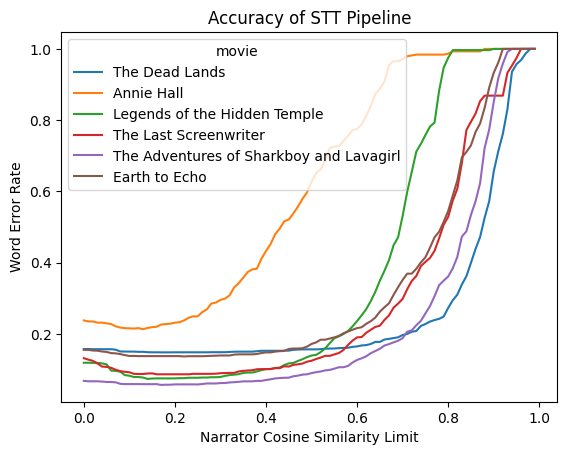

In [9]:
results_df = pd.DataFrame(results)

sns.lineplot(results_df, x='lim', y='wer', hue='movie')
plt.ylabel('Word Error Rate')
plt.xlabel('Narrator Cosine Similarity Limit')
plt.title('Accuracy of STT Pipeline')

In [52]:
weights = np.array(word_counts) / sum(word_counts)
(results_df[results_df.lim.eq(0.14)]['wer'].values * weights).sum().round(4)

np.float64(0.115)

In [ ]:
results = []

for ii, config in enumerate(config_list):
    logging.info(f'NEW CONFIG RUN: \t{ii} / {len(config_list)}')
    for movie_name in movies:
        # da.wipe_movie_files(movie_name)

        vad_df_path = os.path.join(da.voice_activity_dir, f'{movie_name}-vad.parquet')
        seg_df_path = os.path.join(da.diarization_dir, f'{movie_name}-diarization.parquet')
        curr_transcript_fp = os.path.join(da.transcription_dir, da.transcript_df_fp.format(movie_name=movie_name))
        wav_filepath = os.path.join(da.trans_mp3_dir, f'{movie_name}_speech_only.wav')
    
        use_vad = config['use_vad']
        silero_threshold = config['silero_threshold']
        whisper_model = config['whisper_model']
        cosine_sim_lim = config['cosine_sim_lim']
        whisper_config['beam_size'] = config['beam_size']
        whisper_config['no_speech_threshold'] = config['no_speech_threshold']
        whisper_config['condition_on_previous_text'] = config['condition_on_previous_text']
        min_seg_sec = config['min_seg_sec']
        
        # stt.apply_pyannote_vad_to_wav(mp3_filename, wav_filepath, vad_df_path, device, credits_df)
        # stt.apply_silero_vad_to_wav(mp3_filename, wav_filepath, vad_df_path, silero_threshold=silero_threshold, credits_df=credits_df)
        # stt.apply_diarization(movie_name, wav_filepath, diarization_model, seg_df_path, device)
        # stt.add_pyannote_cosine_sim(seg_df_path, wav_filepath, min_seg_sec=min_seg_sec, device=device)
        stt.transcribe_segments(curr_transcript_fp, seg_df_path, wav_filepath, whisper_model, whisper_config, narr_cosine_sim_lim, device)
        
        wer = da.calc_wer(movie_name)
        results.append({'wer': wer})
        print(results[-1])

In [90]:
movie_name = 'Earth to Echo'
trans_df = pd.read_parquet(os.path.join(da.transcription_dir, da.transcript_df_fp.format(movie_name=movie_name)))
trans_df = trans_df[trans_df['text'].ne(' Thank you.')]
trans_txt = ''.join(trans_df.text.str.replace('[\.,"\?!]', '', regex=True)).lower().replace('-', ' ')

with open(os.path.join(da.transcription_dir, 'manual', f'{movie_name}.txt')) as fileobj:
    raw_txt = fileobj.read()
ref_txt = re.sub('[\.,"\?!:]', '', raw_txt).lower().replace('-', ' ').replace('\n', ' ')

stt.visualise_wer_differences(trans_txt, ref_txt)
wer.compute(predictions=[trans_txt], references=[ref_txt])

a flash of blue light beams in space then particles pull away revealing a vast blue tinged galaxy large black letters float|flow into the centre|center of the interstellar view and form a word relativity in another logo a comet zips by light connected by white dots form the letter p the word film forms underneath daytime in a living room a black boy sets up a video camera for a white boy who sits in an arm chair|armchair he removes his light brown coat revealing a black button up shirt a black lab lumbers in on screen reginald munch barrett resident 13 years blonde munch lowers his eyes then|and looks back up outside a boy looks out over a banister alex nichols resident 4 years the video pauses videos uploaded by tuck simms|tucksims the black boy scroll past in another video title mulberry ballers club alex stands on a beach he sits on a couch and holds up five fingers a white blowing|glowing fan sits nearby a web search reads forced to move a view shows a construction site and large e

0.15514250309789343